# ネットワーク上での疫学モデル
## 疫学モデルの基本
ネットワーク用のライブラリを読み込む。

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
#  伝染モデルをシミュレーションする関数を定義
def simulate_epidemic_model(g, beta=0.5, mu=0.1, eta=-1.0, I_init=10, t_max=50, proc_type="SIR", seed=2021):
    random.seed(seed)
    np.random.seed(seed)

    node_state = np.array(["S" for _ in range(g.number_of_nodes())])
    idx = random.sample(range(g.number_of_nodes()), I_init)
    node_state[idx] = "I"

    result_dict = {
        "time": [0],
        "S": [len(node_state[node_state == 'S'])],
        "I": [len(node_state[node_state == 'I'])],
        "R": [len(node_state[node_state == 'R'])],
    }

    edge_list = np.array(g.edges())

    for t in range(t_max):
        infected_nodes = np.where(node_state == 'I')[0]
        recoverd_nodes = np.where(node_state == 'R')[0]

        try:
            neighboring_nodes1 = edge_list[np.concatenate([np.where(edge_list[:,0] == n)[0] for n in infected_nodes]), 1]
        except:
            result_dict["time"].append(t)
            result_dict['S'].append(len(node_state[node_state == 'S']))
            result_dict['I'].append(len(node_state[node_state == 'I']))
            result_dict['R'].append(len(node_state[node_state == 'R']))

            return pd.DataFrame(result_dict)
        neighboring_nodes2 = edge_list[np.concatenate([np.where(edge_list[:,1] == n)[0] for n in infected_nodes]), 0]

        neighboring_nodes = np.concatenate([neighboring_nodes1, neighboring_nodes2])
        neighboring_susceptible_nodes = neighboring_nodes[node_state[neighboring_nodes] == "S"]


        p_set = np.array([random.random() for _ in range(len(neighboring_susceptible_nodes))])
        newly_infected_nodes = neighboring_susceptible_nodes[p_set < beta]

        node_state[newly_infected_nodes] = 'I'

        p_set = np.array([random.random() for _ in range(len(infected_nodes))])

        if proc_type == "SIS":
            node_state[infected_nodes[p_set < mu]] = 'S'
        else:
            node_state[infected_nodes[p_set < mu]] = 'R'

        
        if proc_type == "SIR" and eta > 0.0:
            p_set = np.array([random.random() for _ in range(len(recoverd_nodes))])
            node_state[recoverd_nodes[p_set < eta]] = 'S'

        result_dict["time"].append(t)
        result_dict['S'].append(len(node_state[node_state == 'S']))
        result_dict['I'].append(len(node_state[node_state == 'I']))
        result_dict['R'].append(len(node_state[node_state == 'R']))


    return pd.DataFrame(result_dict)


In [124]:
# ネットワークの生成(Erdos-Renyi random network)
g = nx.fast_gnp_random_graph(1000, 0.005)


In [141]:
# SISモデル
res = simulate_epidemic_model(g, beta=0.3, mu=0.1, proc_type="SIS", I_init=50, t_max=50, seed=123)


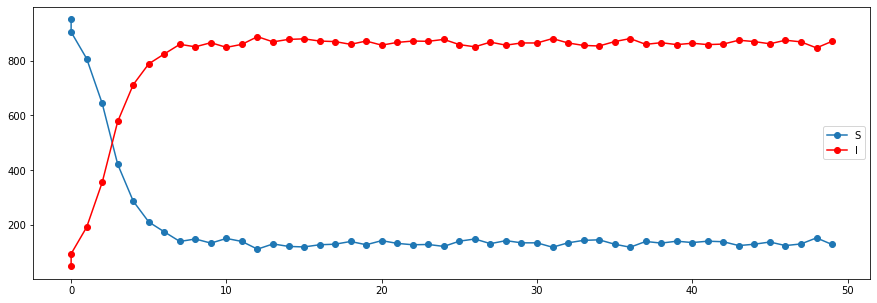

In [142]:
plt.figure(figsize=(15, 5))
plt.plot(res["time"].values, res["S"].values, "o-", label="S")
plt.plot(res["time"].values, res["I"].values, "ro-", label="I")
plt.legend()

In [143]:
# SIR
res = simulate_epidemic_model(g, beta=0.3, mu=0.1, proc_type="SIR", I_init=50, t_max=50, seed=123)

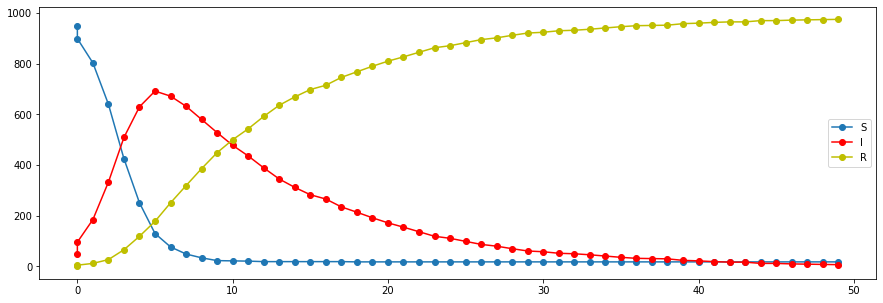

In [144]:
plt.figure(figsize=(15, 5))
plt.plot(res["time"].values, res["S"].values, "o-", label="S")
plt.plot(res["time"].values, res["I"].values, "ro-", label="I")
plt.plot(res["time"].values, res["R"].values, "yo-", label="R")
plt.legend()

In [149]:
# SIRSモデル
res = simulate_epidemic_model(g, beta=0.3, mu=0.1, eta=0.05, proc_type="SIR", I_init=50, t_max=50, seed=123)

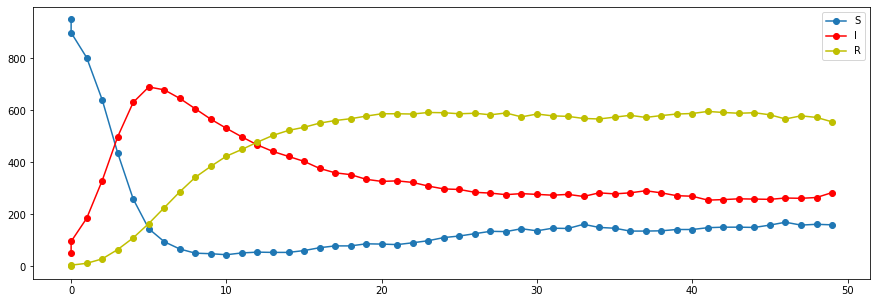

In [150]:
plt.figure(figsize=(15, 5))
plt.plot(res["time"].values, res["S"].values, "o-", label="S")
plt.plot(res["time"].values, res["I"].values, "ro-", label="I")
plt.plot(res["time"].values, res["R"].values, "yo-", label="R")
plt.legend()

## SISモデルにおける相転移

In [171]:
beta_set = [0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.25,0.3,0.4,0.5,0.6]
t_max = 50
pop = []
for beta in beta_set:
    res = simulate_epidemic_model(g, beta=beta, mu=1, proc_type="SIS", I_init=50, t_max=t_max, seed=123)
    pop.append(res['I'].values[-1])

In [182]:
deg = np.array([d for n, d in g.degree()])
beta_c = np.mean(deg) / np.mean(deg ** 2)

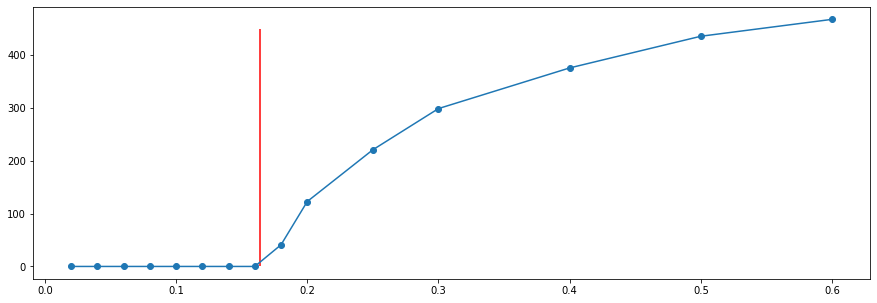

In [186]:
plt.figure(figsize=(15, 5))
plt.plot(beta_set, pop, "o-")
plt.vlines(beta_c, 0, 450, "r")

## ネットワーク構造の違いによる閾値の変化
ネットワークを生成

In [187]:
g_rand = nx.fast_gnp_random_graph(1000, 0.005)
w = nx.utils.powerlaw_sequence(1000, 2.1)
g_sf = nx.expected_degree_graph(w)

In [188]:
pop_rand =[]
pop_sf =[]
for beta in beta_set:
    # ランダムネットワークの場合
    res = simulate_epidemic_model(g_rand, beta=beta, mu=1, proc_type="SIS", I_init=50, t_max=t_max, seed=123)
    pop_rand.append(res['I'].values[-1])
    # スケールフリーネットワークの場合
    res = simulate_epidemic_model(g_sf, beta=beta, mu=1, proc_type="SIS", I_init=50, t_max=t_max, seed=123)
    pop_sf.append(res['I'].values[-1])

In [192]:
deg = np.array([d for n, d in g_rand.degree()])
beta_c_rand = np.mean(deg) / np.mean(deg ** 2)

deg = np.array([d for n, d in g_sf.degree()])
beta_c_sf = np.mean(deg) / np.mean(deg ** 2)

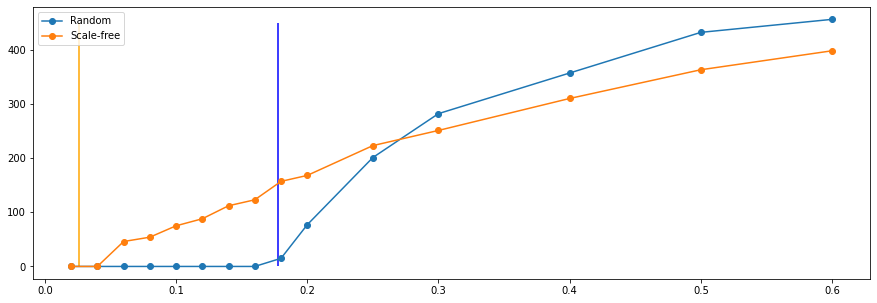

In [194]:
plt.figure(figsize=(15, 5))
plt.plot(beta_set, pop_rand, "o-", label="Random")
plt.plot(beta_set, pop_sf, "o-", label="Scale-free")
plt.vlines(beta_c_rand, 0, 450, "b")
plt.vlines(beta_c_sf, 0, 450, "orange")

plt.legend()